In [1]:
# Importamos la librerias necesarias
import os
import time
import numpy as np
import imageio.v2 as io
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import copy
from sklearn import metrics
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
#Definición de constantes
batch_size = 100
num_epochs = 100

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [3]:
#Preparación de los datos

#Transformaciones a aplicar
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

#Creación de los dataloader de entrenamiento y validación
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
valid_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

#Separamos algunas imágenes del dataset de validación para usar como prueba
indices = list(range(len(valid_dataset)))
np.random.shuffle(indices)
#El set de validación posee 10000 imágenes, así que extraemos 1000 para test.
split = int(np.floor(0.1 * len(valid_dataset)))
valid_sample = torch.utils.data.sampler.SubsetRandomSampler(indices[:-split])
test_sample = torch.utils.data.sampler.SubsetRandomSampler(indices[-split:])

#Dataloaders
trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

validloader = torch.utils.data.DataLoader(
    valid_dataset,
    sampler = valid_sample,
    batch_size = batch_size,
    shuffle=False)
testloader = torch.utils.data.DataLoader(
    valid_dataset,
    sampler = test_sample,
    batch_size=batch_size,
    shuffle=False)

# 1º Parte: Red Neuronal Autoencoder Convolucional de varias capas

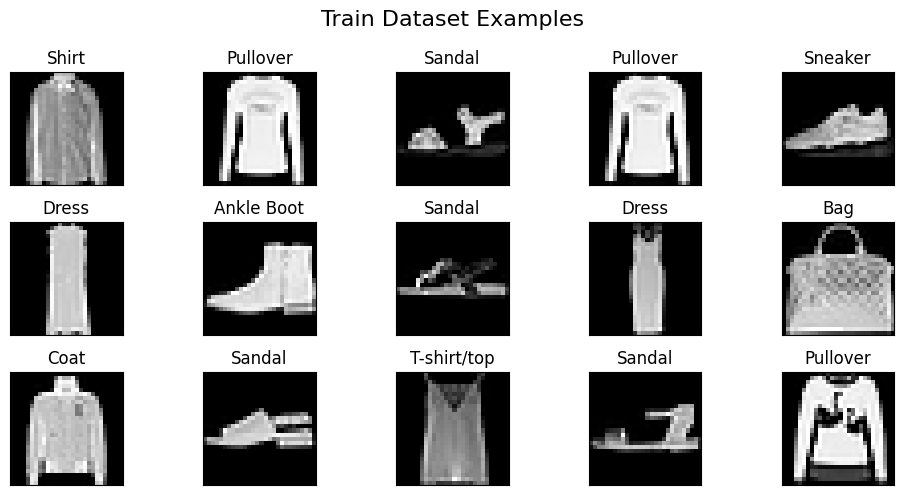

In [32]:
#Visualización de datos del dataset
images, labels = next(iter(trainloader))
filas = 3
columnas = 5

fig_indices = np.random.randint(100, size=filas*columnas)
fig, axs = plt.subplots(filas, columnas, figsize=(10,5))

for i in range(filas):
  for j in range(columnas):
    index = i * columnas + j #+ 1  # Índice automático
    ax = axs[i, j] if filas > 1 else axs[j]
    ax.imshow(np.squeeze(images[fig_indices[index]]), cmap='gray')
    ax.set_title(classes[labels[fig_indices[index]].numpy()])
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Train Dataset Examples', fontsize=16)
plt.tight_layout()
plt.show()

### 1.1 Creación de la red Autoencoder

In [11]:
#Creación de la red feed-forward
class Autoencoder(nn.Module):
    def __init__(self, image_size=28, channels=1, p=0.2, n=64):
        super(Autoencoder, self).__init__()
        self.image_size=image_size
        self.out_linear_enc = n
        self.p = p
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3),
            nn.ReLU(),
            #nn.Dropout(self.p),
            nn.MaxPool2d(2,2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            #nn.Dropout(self.p),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(in_features=32*5*5, out_features=self.out_linear_enc),
            nn.ReLU(),
            #nn.Dropout(self.p)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.out_linear_enc, out_features=32*5*5),
            nn.ReLU(),
            #nn.Dropout(self.p),
            nn.Unflatten(dim=1, unflattened_size=(32,5,5)),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, output_padding=1),
            nn.ReLU(),
            #nn.Dropout(self.p),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, output_padding=1),
            #nn.Sigmoid(),
            nn.ReLU()
            #nn.Dropout(self.p)
        )

    def forward(self, x):
        x_ = self.encoder(x)
        y = self.decoder(x_)
        return y

net = Autoencoder(n=256)
net = net.to(device)
#print(net)
summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
            Conv2d-4           [-1, 32, 11, 11]           4,640
              ReLU-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
           Flatten-7                  [-1, 800]               0
            Linear-8                  [-1, 256]         205,056
              ReLU-9                  [-1, 256]               0
           Linear-10                  [-1, 800]         205,600
             ReLU-11                  [-1, 800]               0
        Unflatten-12             [-1, 32, 5, 5]               0
  ConvTranspose2d-13           [-1, 16, 13, 13]           8,208
             ReLU-14           [-1, 16,

### 1.2 Visualización de datos del dataset predichos por la red sin entrenar

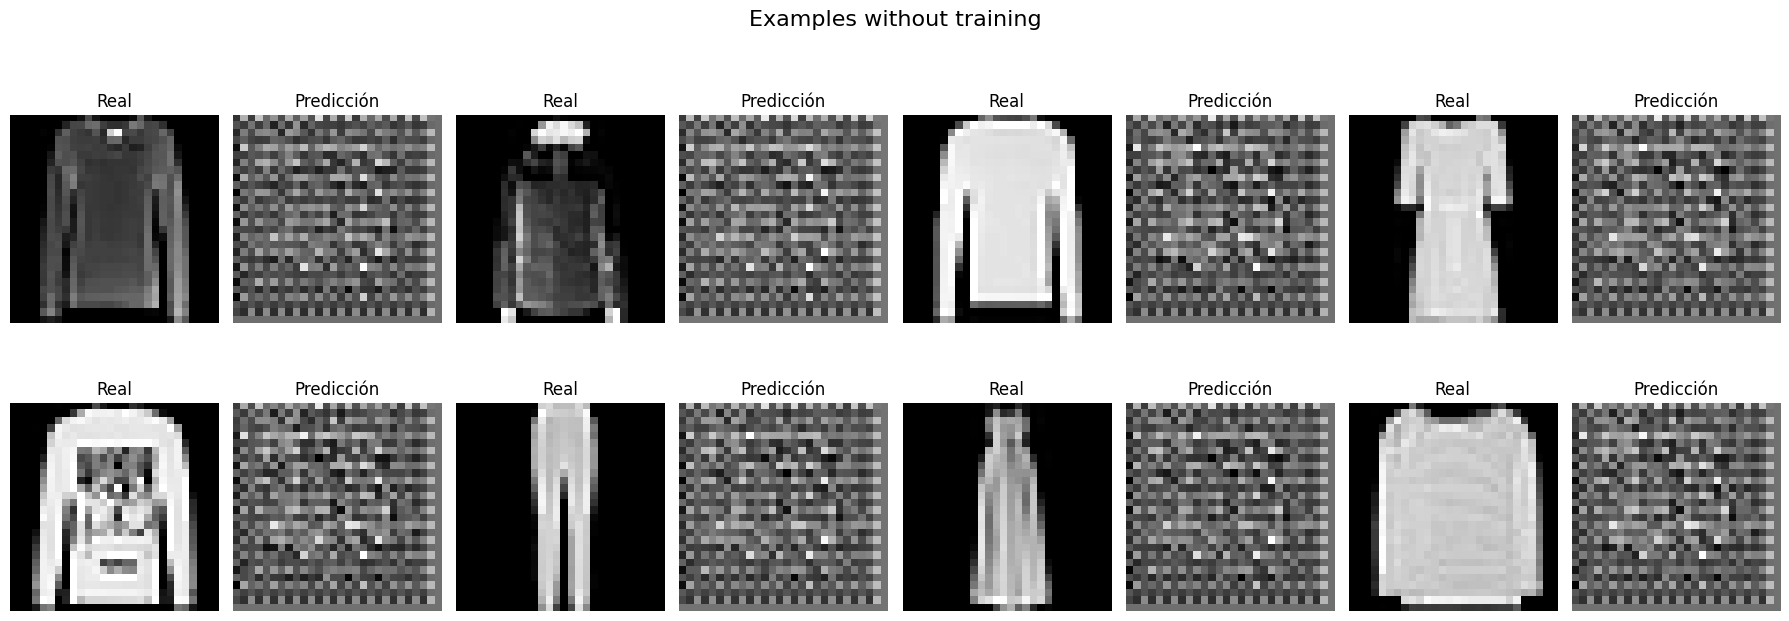

In [34]:
#Visualización de datos del dataset predichos por la red sin entrenar
images, labels = next(iter(trainloader))
images = images.to(device)
filas = 2
columnas = 4

fig_indices = np.random.randint(100, size=filas*columnas)
fig, axs = plt.subplots(filas, 2 * columnas, figsize=(18,7))

outputs = net(images)

for i in range(filas):
    for j in range(columnas):
        # Imagen Real
        axs[i, 2 * j].imshow(np.squeeze(images.cpu().detach().numpy())[i * columnas + j], cmap='gray')
        axs[i, 2 * j].axis('off')
        axs[i, 2 * j].set_title('Real')

        # Imagen Predicha
        axs[i, 2 * j + 1].imshow(np.squeeze(outputs.cpu().detach().numpy())[i * columnas + j], cmap='gray')
        axs[i, 2 * j + 1].axis('off')
        axs[i, 2 * j + 1].set_title('Predicción')

fig.suptitle('Examples without training', fontsize=16)
plt.tight_layout()
plt.show()

### 1.2 Entrenamiento del Autoencoder

In [6]:
#Training loop
train_loss = []
real_train_loss = []
valid_loss =[]
best_vloss = np.Inf #Se inicia en un valor muy alto para asegurarse que se actualice en la primera época

intermediate_save_folder = r"./autoencoder_256"

if not os.path.exists(intermediate_save_folder):
  os.mkdir(intermediate_save_folder)

timgs, tlabels = next(iter(testloader)) #Imagenes para tomar cada X epocas para ver graficamente como evoluciona el entrenamiento
                                        # Se crea el iterador fuera del ciclo de entrenamiento para que siempre sean las mismas imágenes

Autoencoder_net = Autoencoder(n=128, p=0.2)
Autoencoder_net = Autoencoder_net.to(device)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(Autoencoder_net.parameters(), lr=1e-3)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-3)

def train_one_epoch(epoch_index):
    running_loss = 0
    Autoencoder_net.train()

    for j, data in enumerate(trainloader):
        #inicio = time.time()
        images, labels = data
        images = images.to(device)
        #labels = labels.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        #make predictions
        outputs = Autoencoder_net(images)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, images)
        #print(loss)

        # Backpropagate the error
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        #lr_scheduler.step(epoch_index + j / len(trainloader))
        # Gather data and report
        running_loss += loss.item()

    return running_loss / (j + 1)

def valid_one_epoch(epoch_index):
    # We don't need gradients on to do reporting
    running_vloss = 0.0
    running_real_loss = 0.0
    Autoencoder_net.eval()

    with torch.no_grad():
        for l, data in enumerate(trainloader):
            imgs, labels = data
            imgs = imgs.to(device)

            outputs = Autoencoder_net(imgs)

            real_loss = loss_fn(outputs, imgs)
            running_real_loss += real_loss.item()

        avg_real_loss = running_real_loss / (l + 1)

        for k, vdata in enumerate(validloader):
            vimgs, vlabels = vdata
            vimgs = vimgs.to(device)

            voutputs = Autoencoder_net(vimgs)

            vloss = loss_fn(voutputs, vimgs)
            running_vloss += vloss.item()

        avg_vloss = running_vloss / (k + 1)

        return avg_real_loss, avg_vloss


for epoch in range(num_epochs):
    inicio = time.time()

    avg_loss = train_one_epoch(epoch)
    train_loss.append(avg_loss)

    avg_real_loss, avg_vloss = valid_one_epoch(epoch)
    valid_loss.append(avg_vloss)
    real_train_loss.append(avg_real_loss)

    fin = time.time()
    print(f'Epoch {epoch + 1} - Wrong_Train_loss: {avg_loss} - Real_Train_loss: {avg_real_loss} - Valid_loss: {avg_vloss} - lr: {optimizer.param_groups[0]["lr"]} - Tiempo: {np.round((fin-inicio)/60.0,4)} minutos - Estimado: {np.round(((num_epochs-epoch-1)*(fin-inicio))/60.0, 2)} minutos')

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = rf'./models/best_autoencoder.pth'
        torch.save(Autoencoder_net.state_dict(), model_path)

    # Save intermediate train images
    if epoch % 40 == 0:
        n_image = 0
        timgs = timgs.to(device)
        toutputs = Autoencoder_net(timgs)
        timgs_numpy = timgs.cpu().detach().numpy()
        toutputs_numpy = toutputs.cpu().detach().numpy()
        for idx in range(5):
            if epoch == 0:
                original = (timgs_numpy[idx][0]*255).astype('uint8')
                io.imsave(os.path.join(intermediate_save_folder, f'original_{epoch}_{n_image}.png'), original)
            pred = (toutputs_numpy[idx][0]*255).astype('uint8')
            io.imsave(os.path.join(intermediate_save_folder, f'prediction_{epoch}_{n_image}.png'), pred)
            n_image += 1

Epoch 1 - Wrong_Train_loss: 0.1728981055319309 - Real_Train_loss: 0.14887637148300806 - Valid_loss: 0.14921625041299397 - lr: 0.001 - Tiempo: 0.2251 minutos - Estimado: 22.29 minutos
Epoch 2 - Wrong_Train_loss: 0.12359186622003714 - Real_Train_loss: 0.138500698034962 - Valid_loss: 0.13901211073001227 - lr: 0.001 - Tiempo: 0.2289 minutos - Estimado: 22.44 minutos
Epoch 3 - Wrong_Train_loss: 0.1139135055243969 - Real_Train_loss: 0.1335909432421128 - Valid_loss: 0.1341180478533109 - lr: 0.001 - Tiempo: 0.2397 minutos - Estimado: 23.25 minutos
Epoch 4 - Wrong_Train_loss: 0.10838322670509418 - Real_Train_loss: 0.12789635968705018 - Valid_loss: 0.12844456980625787 - lr: 0.001 - Tiempo: 0.2426 minutos - Estimado: 23.29 minutos
Epoch 5 - Wrong_Train_loss: 0.10478641452888647 - Real_Train_loss: 0.1241568465406696 - Valid_loss: 0.12472522010405858 - lr: 0.001 - Tiempo: 0.2443 minutos - Estimado: 23.21 minutos
Epoch 6 - Wrong_Train_loss: 0.10292768273502588 - Real_Train_loss: 0.11916799607376258 

In [7]:
np.save(r'.\autoencoder\autoencoder_256\train_losses_auto_256.npy', train_loss)
np.save(r'.\autoencoder\autoencoder_256\real_train_losses_auto_256.npy', real_train_loss)
np.save(r'.\autoencoder\autoencoder_256\valid_losses_auto_256.npy', valid_loss)

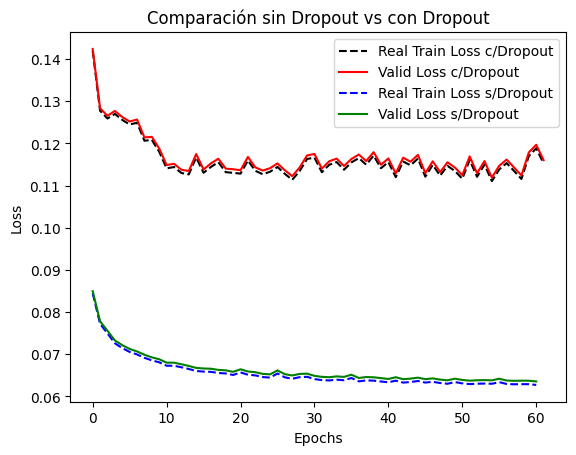

In [9]:
real_train_loss_drop = np.load(r'.\autoencoder\autoencoder_64_drop\real_train_losses_auto_64.npy')
valid_loss_drop = np.load(r'.\autoencoder\autoencoder_64_drop\valid_losses_auto_64.npy')

real_train_loss_sindrop = np.load(r'.\autoencoder\autoencoder_64\real_train_losses_auto_64.npy')
valid_loss_sindrop = np.load(r'.\autoencoder\autoencoder_64\valid_losses_auto_64.npy')

plt.plot(real_train_loss_drop,'k--', label='Real Train Loss c/Dropout')
plt.plot(valid_loss_drop,'r-', label='Valid Loss c/Dropout')

plt.plot(real_train_loss_sindrop[:61],'b--', label='Real Train Loss s/Dropout')
plt.plot(valid_loss_sindrop[:61],'g-', label='Valid Loss s/Dropout')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Comparación sin Dropout vs con Dropout')
plt.legend()
plt.show()

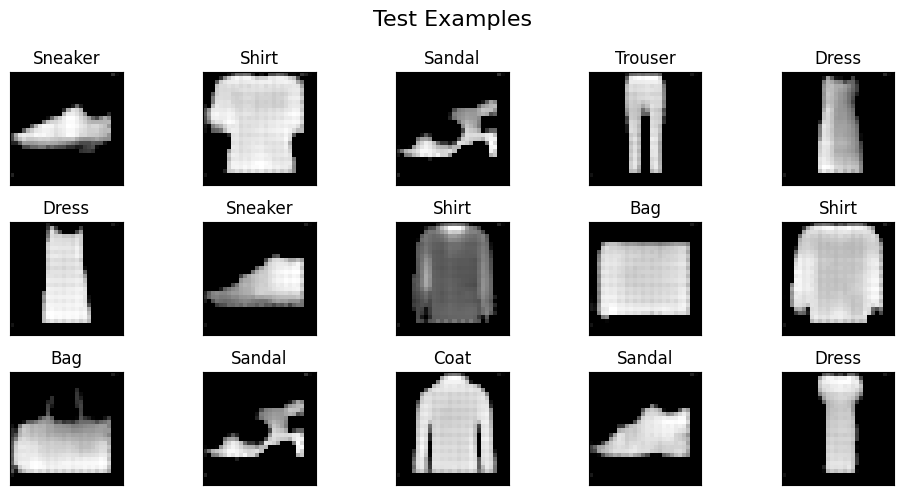

In [9]:
Autoencoder_net.eval()
n_image = 0
with torch.no_grad():
    timgs, tlabels = next(iter(testloader))
    timgs = timgs.to(device)

    toutputs = Autoencoder_net(timgs)
    toutputs = toutputs.cpu().detach().numpy()

    for idx in range(len(timgs)):
      original = (timgs[idx].cpu().detach().numpy()[0]*255).astype('uint8')
      pred = (toutputs[idx][0]*255).astype('uint8')
      #io.imsave(os.path.join(original_save_folder, f'{n_image}.png'), original)
      #io.imsave(os.path.join(pred_save_folder, f'{n_image}.png'), pred)
      n_image += 1

filas = 3
columnas = 5
fig_indices = np.random.randint(100, size=filas*columnas)
fig, axs = plt.subplots(filas, columnas, figsize=(10,5))

for i in range(filas):
  for j in range(columnas):
    index = i * columnas + j #+ 1  # Índice automático
    ax = axs[i, j] if filas > 1 else axs[j]
    ax.imshow(np.squeeze(toutputs[fig_indices[index]][0]), cmap='gray')
    ax.set_title(classes[tlabels[fig_indices[index]].numpy()])
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Test Examples', fontsize=16)
plt.tight_layout()
plt.show()


### 1.1 Análisis de resultados comparando varias redes que dieron los mejores resultados

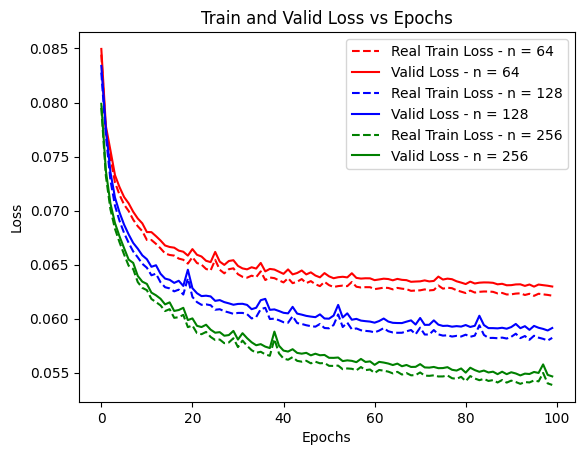

In [13]:
real_train_loss_64 = np.load(r'.\autoencoder\autoencoder_64\real_train_losses_auto_64.npy')
valid_loss_64 = np.load(r'.\autoencoder\autoencoder_64\valid_losses_auto_64.npy')

real_train_loss_128 = np.load(r'.\autoencoder\autoencoder_128\real_train_losses_auto_128.npy')
valid_loss_128 = np.load(r'.\autoencoder\autoencoder_128\valid_losses_auto_128.npy')

real_train_loss_256 = np.load(r'.\autoencoder\autoencoder_256\real_train_losses_auto_256.npy')
valid_loss_256 = np.load(r'.\autoencoder\autoencoder_256\valid_losses_auto_256.npy')

plt.figure()

plt.plot(real_train_loss_64,'r--', label='Real Train Loss - n = 64')
plt.plot(valid_loss_64,'r-', label='Valid Loss - n = 64')

plt.plot(real_train_loss_128,'b--', label='Real Train Loss - n = 128')
plt.plot(valid_loss_128,'b-', label='Valid Loss - n = 128')

plt.plot(real_train_loss_256,'g--', label='Real Train Loss - n = 256')
plt.plot(valid_loss_256,'g-', label='Valid Loss - n = 256')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train and Valid Loss vs Epochs')
plt.legend()
plt.show()

Dado que se observa una disminución en el error al aumentar el número de neuronas, vamos a entrenar el clasificador empleando 256 neuronas para obtener el mejor resultado

# 2º Parte: Clasificador Autoencoder

In [4]:
#Creación de la red feed-forward
class Autoencoder(nn.Module):
    def __init__(self, image_size=28, channels=1, p=0.2, n=64):
        super(Autoencoder, self).__init__()
        self.image_size=image_size
        self.out_linear_enc = n
        self.p = p
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3),
            nn.ReLU(),
            #nn.Dropout(self.p),
            nn.MaxPool2d(2,2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            #nn.Dropout(self.p),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(in_features=32*5*5, out_features=self.out_linear_enc),
            nn.ReLU(),
            #nn.Dropout(self.p)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.out_linear_enc, out_features=32*5*5),
            nn.ReLU(),
            #nn.Dropout(self.p),
            nn.Unflatten(dim=1, unflattened_size=(32,5,5)),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, output_padding=1),
            nn.ReLU(),
            #nn.Dropout(self.p),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, output_padding=1),
            #nn.Sigmoid(),
            nn.ReLU()
            #nn.Dropout(self.p)
        )

    def forward(self, x):
        x_ = self.encoder(x)
        y = self.decoder(x_)
        return y

In [5]:
autoencoder = Autoencoder(n=256)
autoencoder.load_state_dict(torch.load(r'.\autoencoder\autoencoder_256\best_autoencoder.pth'))

<All keys matched successfully>

In [6]:
class Autoencoder_clasiffier(nn.Module):
    def __init__(self, autoencoder=None):
        super(Autoencoder_clasiffier, self).__init__()
        if autoencoder == None:
            self.n = 256
            self.p = 0.2
            self.encoder = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
                nn.ReLU(),
                #nn.Dropout(self.p),
                nn.MaxPool2d(2,2),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                nn.ReLU(),
                #nn.Dropout(self.p),
                nn.MaxPool2d(2,2),

                nn.Flatten(),
                nn.Linear(in_features=32*5*5, out_features=self.n),
                nn.ReLU(),
                #nn.Dropout(self.p)
            )
        else:
            self.encoder = copy.deepcopy(autoencoder.encoder)
            self.n = autoencoder.out_linear_enc
            self.p = autoencoder.p
        
        self.clasiffier = nn.Sequential(
            nn.Linear(in_features=self.n, out_features=10),
            #nn.ReLU(),
            nn.Sigmoid(),
            #nn.Softmax()
            #nn.Dropout()
        )
    
    def forward(self, x):
        x_ = self.encoder(x)
        y = self.clasiffier(x_)
        return y

#classifier_net = Autoencoder_clasiffier()
classifier_net = Autoencoder_clasiffier(autoencoder=autoencoder)
classifier_net = classifier_net.to(device)
#print(classifier_net)
summary(classifier_net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
            Conv2d-4           [-1, 32, 11, 11]           4,640
              ReLU-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
           Flatten-7                  [-1, 800]               0
            Linear-8                  [-1, 256]         205,056
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
          Sigmoid-11                   [-1, 10]               0
Total params: 212,426
Trainable params: 212,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [7]:
lr = 1e-3
loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.Adam(classifier_net.clasiffier.parameters(), lr=lr) #Entrenar solo la última capa
optimizer = optim.Adam(classifier_net.parameters(), lr=lr)

In [8]:
#Training loop
train_loss = []
real_train_loss = []
valid_loss = []
acc = []
best_vloss = np.Inf #Se inicia en un valor muy alto para asegurarse que se actualice en la primera época

timgs, tlabels = next(iter(testloader)) #Imagenes para tomar cada X epocas para ver graficamente como evoluciona el entrenamiento
                                        # Se crea el iterador fuera del ciclo de entrenamiento para que siempre sean las mismas imágenes

def train_one_epoch(epoch_index):
    running_loss = 0
    classifier_net.train()

    for j, data in enumerate(trainloader):
        #inicio = time.time()
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        #make predictions
        outputs = classifier_net(images)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        #print(loss)

        # Backpropagate the error
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    return running_loss / (j + 1)

def valid_one_epoch(epoch_index):
    # We don't need gradients on to do reporting
    running_vloss = 0.0
    running_real_loss = 0.0
    running_acc = 0.0
    correct = 0    
    total = 0
    
    classifier_net.eval()
    with torch.no_grad():
        for l, data in enumerate(trainloader):
            imgs, labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = classifier_net(imgs)

            real_loss = loss_fn(outputs, labels)
            running_real_loss += real_loss.item()

        avg_real_loss = running_real_loss / (l + 1)

        for k, vdata in enumerate(validloader):
            vimgs, vlabels = vdata
            vimgs = vimgs.to(device)
            vlabels = vlabels.to(device) 

            voutputs = classifier_net(vimgs)

            #Loss
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            #Accuracy
            _, predicted = torch.max(voutputs.data, 1)        
            total += vlabels.size(0)        
            correct += (predicted == vlabels).sum().item() 
            running_acc += correct / total
        
        avg_vloss = running_vloss / (k + 1)
        avg_acc = running_acc / (k + 1)

        return avg_real_loss, avg_vloss, avg_acc


for epoch in range(num_epochs):
    inicio = time.time()

    avg_loss = train_one_epoch(epoch)
    train_loss.append(avg_loss)

    avg_real_loss, avg_vloss, avg_acc = valid_one_epoch(epoch)
    valid_loss.append(avg_vloss)
    real_train_loss.append(avg_real_loss)
    acc.append(avg_acc)

    fin = time.time()
    print(f'Epoch {epoch + 1} - Accuracy: {avg_acc} - Real_Train_loss: {avg_real_loss} - Valid_loss: {avg_vloss} - Tiempo: {np.round((fin-inicio)/60.0,4)} minutos - Estimado: {np.round(((num_epochs-epoch-1)*(fin-inicio))/60.0, 2)} minutos')

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = rf'.\classifier\classifier_256_pretrained\best.pth'
        torch.save(classifier_net.state_dict(), model_path)

Epoch 1 - Accuracy: 0.7409385108748533 - Real_Train_loss: 1.6045228493213655 - Valid_loss: 1.6106052902009753 - Tiempo: 0.4236 minutos - Estimado: 41.94 minutos
Epoch 2 - Accuracy: 0.8449678919956896 - Real_Train_loss: 1.5656927897532782 - Valid_loss: 1.5752724674012926 - Tiempo: 0.4144 minutos - Estimado: 40.61 minutos
Epoch 3 - Accuracy: 0.8545661641365393 - Real_Train_loss: 1.5515302805105846 - Valid_loss: 1.559450876712799 - Tiempo: 0.4129 minutos - Estimado: 40.05 minutos
Epoch 4 - Accuracy: 0.8673300036439785 - Real_Train_loss: 1.5402135463555653 - Valid_loss: 1.5526123762130737 - Tiempo: 0.4125 minutos - Estimado: 39.6 minutos
Epoch 5 - Accuracy: 0.8784860137406905 - Real_Train_loss: 1.5356064335505168 - Valid_loss: 1.5485064135657416 - Tiempo: 0.417 minutos - Estimado: 39.62 minutos
Epoch 6 - Accuracy: 0.8753058999071202 - Real_Train_loss: 1.5332336072127024 - Valid_loss: 1.545863597922855 - Tiempo: 0.4136 minutos - Estimado: 38.88 minutos
Epoch 7 - Accuracy: 0.875356003851729 

In [9]:
np.save(r'.\classifier\classifier_256_pretrained\classifier_train_losses_256.npy', train_loss)
np.save(r'.\classifier\classifier_256_pretrained\classifier_real_train_losses_256.npy', real_train_loss)
np.save(r'.\classifier\classifier_256_pretrained\classifier_valid_losses_256.npy', valid_loss)
np.save(r'.\classifier\classifier_256_pretrained\classifier_acc_256.npy', acc)

In [ ]:
real_train_loss_64_no_pretrained = np.load(r'.\classifier\classifier_64_no_pretrained\classifier_real_train_losses_64.npy')
valid_loss_64_no_pretrained = np.load(r'.\classifier\classifier_64_no_pretrained\classifier_valid_losses_64.npy')

real_train_loss_256_no_pretrained = np.load(r'.\classifier\classifier_256_no_pretrained\classifier_real_train_losses_256.npy')
valid_loss_256_no_pretrained = np.load(r'.\classifier\classifier_256_no_pretrained\classifier_valid_losses_256.npy')


real_train_loss_64_pretrained = np.load(r'.\classifier\classifier_64_pretrained\classifier_real_train_losses_64.npy')
valid_loss_64_pretrained = np.load(r'.\classifier\classifier_64_pretrained\classifier_valid_losses_64.npy')

real_train_loss_256_pretrained = np.load(r'.\classifier\classifier_256_pretrained\classifier_real_train_losses_256.npy')
valid_loss_256_pretrained = np.load(r'.\classifier\classifier_256_pretrained\classifier_valid_losses_256.npy')

plt.plot(real_train_loss_64_no_pretrained,'r--', label='Real Train Loss - no pretrained - n = 64')
plt.plot(valid_loss_64_no_pretrained,'r-', label='Valid Loss - no pretrained - n = 64')

plt.plot(real_train_loss_256_no_pretrained,'c--', label='Real Train Loss - no pretrained - n = 256')
plt.plot(valid_loss_256_no_pretrained,'c-', label='Valid Loss - no pretrained - n = 256')

plt.plot(real_train_loss_64_pretrained,'m--', label='Real Train Loss - pretrained - n = 64')
plt.plot(valid_loss_64_pretrained,'m-', label='Valid Loss - pretrained - n = 64')

plt.plot(real_train_loss_256_pretrained,'k--', label='Real Train Loss - pretrained - n = 256')
plt.plot(valid_loss_256_pretrained,'k-', label='Valid Loss - pretrained - n = 256')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

In [ ]:
accuracy_64_no_pretrained = np.load(r'.\classifier\classifier_64_no_pretrained\classifier_acc_64.npy')
accuracy_256_no_pretrained = np.load(r'.\classifier\classifier_256_no_pretrained\classifier_acc_256.npy')

accuracy_64_pretrained = np.load(r'.\classifier\classifier_64_pretrained\classifier_acc_64.npy')
accuracy_256_pretrained = np.load(r'.\classifier\classifier_256_pretrained\classifier_acc_256.npy')

plt.plot(accuracy_64_no_pretrained,'r-', label='Accuracy - no_pretrained - n = 64')
plt.plot(accuracy_256_no_pretrained,'c-', label='Accuracy - no_pretrained - n = 256')
plt.plot(accuracy_64_pretrained,'m--', label='Accuracy - pretrained - n = 64')
plt.plot(accuracy_256_pretrained,'k--', label='Accuracy - pretrained - n = 256')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

In [14]:
#net = Autoencoder()
#net.load_state_dict(torch.load(r'./best.pth'))
#net = net.to(device)

classifier_net = Autoencoder_clasiffier()
classifier_net.load_state_dict(torch.load(r'.\classifier\classifier_256_no_pretrained\best.pth'))
classifier_net = classifier_net.to(device)

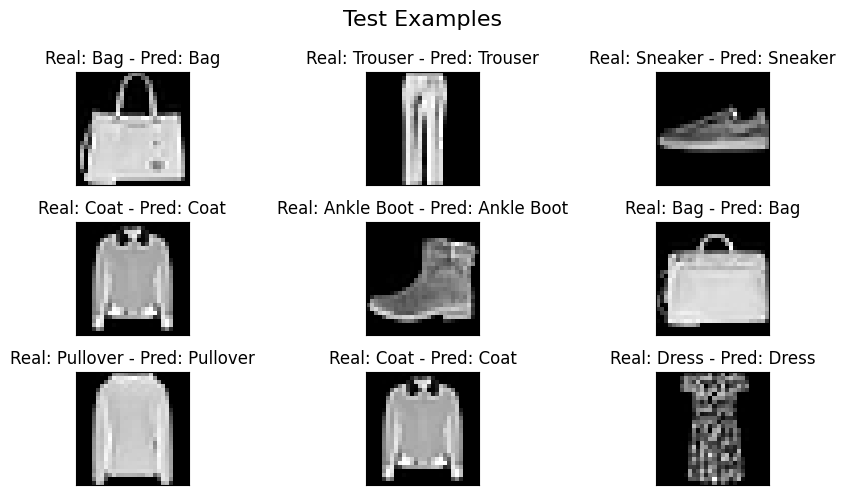

In [24]:
classifier_net.eval()
predictions = []
real = []

with torch.no_grad():
  timgs, tlabels = next(iter(testloader))
  timgs = timgs.to(device)

  toutputs = classifier_net(timgs)
  _, predicted = torch.max(toutputs.data, 1)
  timgs = timgs.cpu().detach().numpy()
  predictions.append(predicted.cpu().detach().numpy())
  real.append(tlabels.cpu().detach().numpy())

predictions = [item for lista in predictions for item in lista]
real = [item for lista in real for item in lista]

filas = 3
columnas = 3

fig_indices = np.random.randint(100, size=filas*columnas)
fig, axs = plt.subplots(filas, columnas, figsize=(10,5))

for i in range(filas):
  for j in range(columnas):
    index = i * columnas + j #+ 1  # Índice automático
    ax = axs[i, j] if filas > 1 else axs[j]
    ax.imshow(np.squeeze(timgs[fig_indices[index]][0]), cmap='gray')
    #ax.set_title(f'Real: {classes[tlabels[fig_indices[index]].numpy()]} - Pred: {classes[predictions[fig_indices[index]]]}')
    ax.set_title(f'Real: {classes[real[fig_indices[index]]]} - Pred: {classes[predictions[fig_indices[index]]]}')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Test Examples', fontsize=16)
plt.tight_layout()
plt.show()

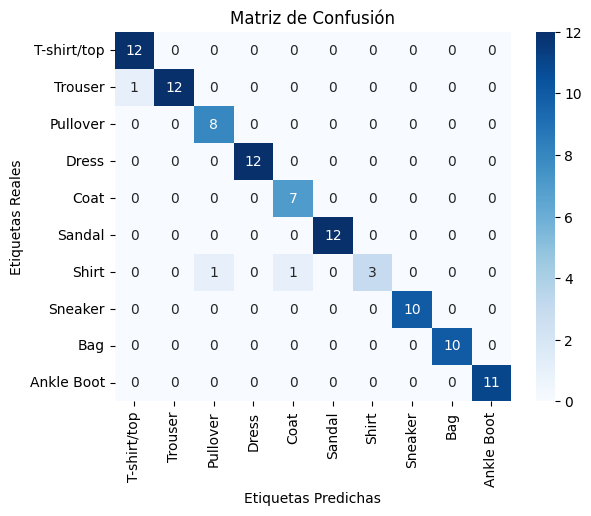

In [29]:
confusion_matrix = metrics.confusion_matrix(real, predictions)

# Crear un heatmap con Seaborn
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[valor] for valor in np.unique(real)], 
            yticklabels=[classes[valor] for valor in np.unique(predictions)])

# Configuraciones adicionales para mejorar la visualización
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
# Rotar los labels del eje x
plt.xticks(rotation=90)
plt.show()